In [1]:
import math
import random as rand
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, double
# from concurrent.futures import ThreadPoolExecutor
# from copy import deepcopy
import time



############################################### options for optimisation #############################################
#
# jit
# 
# double sum -> even better, average phase, then ...? wait what?
# 
#####################################################################################################################





class Oscillator:

    def __init__(self, initPhase, omega):
        self.omega = omega
        self.lastTheta = 0.0                                            # gets value immediately, but instantiate type
        self.currentTheta = initPhase                                   # handed over immediately on first run to lastTheta




class OscPopulation:

    def __init__(self, omegaDistr = 'normal'):
        # list of objects  
        self.list_os = np.zeros(N, dtype = Oscillator)                      # pre-allocate with fixed size -> speed gain?
        self.omegaDistr = omegaDistr
       
       # complete initialisation
        for n in range(N):
            if omegaDistr == 'normal': omega = rand.normalvariate(0,1)
            elif omegaDistr == 'uniform': omega = rand.uniform(-0.5, 0.5)
                    
            initPhase = rand.uniform(0, math.tau)        
            
            self.list_os[n] = Oscillator(initPhase, omega)

        print('oscillators initialised with', omegaDistr.upper(), 'distibution of omegas' )



    def reRandomise(self):

        for n in range(N):
            # omega
            if self.omegaDistr == 'normal': newOmega = rand.normalvariate(0.0,1.0)
            elif self.omegaDistr == 'uniform': newOmega = rand.uniform(-0.5, 0.5)  
            # theta
            newInitPhase = rand.uniform(0, math.tau)      
            
            self.list_os[n].omega = newOmega
            self.list_os[n].lastTheta = 0.0                                             # gets value immediately, but instantiate type
            self.list_os[n].currenTtheta = newInitPhase                                    # handed over immediately on first run to lastTheta
            

        print('## 3 variables re-randomised ##' )        



    ############ calculate r ############
    def calc_r(self):                                       
        
        ###### one way to do it #######
        # complex sum of all phases 
        # realSum = 0 
        # imaginarySum = 0

        # for n in range(N): 
        #     realSum += math.cos(self.list_os[n].theta[-1])
        #     imaginarySum += math.sin(self.list_os[n].theta[-1])
        
        # realSum = realSum/N 
        # imaginarySum = imaginarySum/N
        # r = math.sqrt(realSum * realSum + imaginarySum * imaginarySum)


        ###### another way to do it #######
        sum = 0.0 + 0.0j
        for n in range(N):
            sum += math.e**(1.0j * self.list_os[n].currentTheta)                             
        sum = sum / N 

        # r = math.sqrt(sum.real**2 + sum.imag**2)
        r = abs(sum)
        
        return r

    

    # wrapper method
    def stepAll(self, K):

        # getter: from objects
        lastThetaList = []
        currentThetaList = []
        omegaList = []

        for n in range(N):
            lastThetaList.append(self.list_os[n].lastTheta)
            currentThetaList.append(self.list_os[n].currentTheta)
            omegaList.append(self.list_os[n].omega)

        # converting
        lastThetaArray = np.array(lastThetaList)
        currentThetaArray = np.array(currentThetaList)
        omegaArray = np.array(omegaList)

        # up until here its totally fine, values are correctly transmitted

        # calculating, handing over
        newLastThetaArray, newCurrentThetaArray = self._stepAll(lastThetaArray, currentThetaArray, omegaArray, K)

        # conversion, just in case
        lastThetaList = newLastThetaArray.tolist()
        currentThetaList = newCurrentThetaArray.tolist()



        # setter: back to OOP
        for n in range(N):
            self.list_os[n].lastTheta = lastThetaList[n]
            self.list_os[n].currentTheta = currentThetaList[n]

    
    
    # step FOR time t -> use t-1 ####################################
    @staticmethod
    @jit(nopython = True)            #('double[:](double[:], double[:], double[:], int8)', nopython = True)
    def _stepAll(lastThetaArray, currentThetaArray, omegaArray, K):
        
        for n in range(N):                                                                  # step through time -> hand over value
            lastThetaArray[n] = currentThetaArray[n]

        # calculate new thetas
        for n in range(N):
            
            sum = 0.0
            for j in range(N):                                                              # calculate differential sum for ONE oscillator n for time t
                sum += math.sin(lastThetaArray[j] - lastThetaArray[n])                  

            theta_dot_t = omegaArray[n] + K/N * sum                                 # theta_dot_t for oscillator n
            
            theta_t = lastThetaArray[n] + dt * theta_dot_t                          # new theta for oscillator n -> euler step

            currentThetaArray[n] = theta_t                                          # going down list of objects, pick object, dial into theta list, append

        return lastThetaArray, currentThetaArray




    def runK(self):
        
        r_critList= []
                        
        for K in K_range:  
            self.reRandomise()

            for t in t_range:
                self.stepAll(K)

            r_crit = self.calc_r()
            r_critList.append(r_crit)
            print('K = ' + str(round(K,3)) + ' | r_crit = ' + str(round(r_crit, 3)))
            
        return r_critList
                


    def runT(self, K):
        rList = []

        for t in t_range:
            # step all oscillators forward INTO timeperiod t
            self.stepAll(K)

            # calculate the population's coherence at each time step
            r = self.calc_r()
            rList.append(r)
                    
            # status
            if t % 10 == 0: print('t =', t, 'done') 
    
    
        return rList
                








oscillators initialised with NORMAL distibution of omegas
## 3 variables re-randomised ##
K = 0.0 | r_crit = 0.077
## 3 variables re-randomised ##
K = 0.1 | r_crit = 0.009
## 3 variables re-randomised ##
K = 0.2 | r_crit = 0.053
## 3 variables re-randomised ##
K = 0.3 | r_crit = 0.036
## 3 variables re-randomised ##
K = 0.4 | r_crit = 0.025
## 3 variables re-randomised ##
K = 0.5 | r_crit = 0.042
## 3 variables re-randomised ##
K = 0.6 | r_crit = 0.025
## 3 variables re-randomised ##
K = 0.7 | r_crit = 0.087
## 3 variables re-randomised ##
K = 0.8 | r_crit = 0.075
## 3 variables re-randomised ##
K = 0.9 | r_crit = 0.091
## 3 variables re-randomised ##
K = 1.0 | r_crit = 0.105
## 3 variables re-randomised ##
K = 1.1 | r_crit = 0.066
## 3 variables re-randomised ##
K = 1.2 | r_crit = 0.172
## 3 variables re-randomised ##
K = 1.3 | r_crit = 0.132
## 3 variables re-randomised ##
K = 1.4 | r_crit = 0.177
## 3 variables re-randomised ##
K = 1.5 | r_crit = 0.23
## 3 variables re-randomised ##

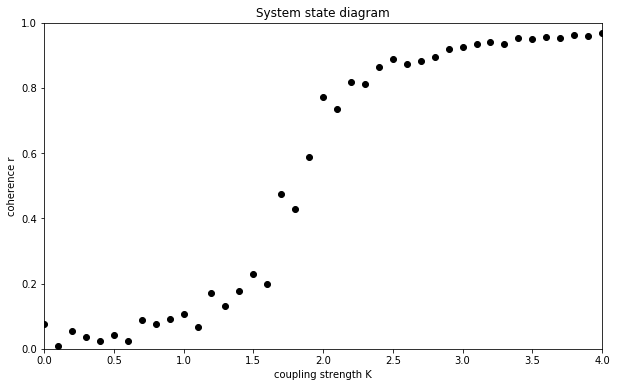

Wall time: 22min 2s


In [2]:
%%time


N = 500             # 1000 
T = 100             # 100
dt = 0.01
K = 4
dk = 0.1

numberOfTimes = int(T/dt)
numberOfK = int(K/dk)
t_range = [round(i * dt, 4) for i in range(numberOfTimes + 1)]
K_range =  [round(i * dk, 4) for i in range(numberOfK + 1)]            


pop1 = OscPopulation('normal')
r_critList = pop1.runK() 


# graphics 
plt.figure(figsize = (10,6))
plt.title('System state diagram')
plt.xlim(0, 4)
plt.ylim(0, 1)
plt.xlabel('coupling strength K')
plt.ylabel('coherence r')

plt.plot(K_range, r_critList, 'ko')
filename = 'graphics/1_K-vs-r' + '_omegaDistr=' + pop1.omegaDistr + '_N=' + str(N) + '_' + str(int(time.time())) + '.pdf'
plt.savefig(filename, dpi = 200, bbox_inches = 'tight')
plt.show()








oscillators initialised with NORMAL distibution of omegas
t = 0.0 done
t = 10.0 done
t = 20.0 done
t = 30.0 done
t = 40.0 done
t = 50.0 done
t = 60.0 done
t = 70.0 done
t = 80.0 done
t = 90.0 done
t = 100.0 done
oscillators initialised with NORMAL distibution of omegas
t = 0.0 done
t = 10.0 done
t = 20.0 done
t = 30.0 done
t = 40.0 done
t = 50.0 done
t = 60.0 done
t = 70.0 done
t = 80.0 done
t = 90.0 done
t = 100.0 done
oscillators initialised with NORMAL distibution of omegas
t = 0.0 done
t = 10.0 done
t = 20.0 done
t = 30.0 done
t = 40.0 done
t = 50.0 done
t = 60.0 done
t = 70.0 done
t = 80.0 done
t = 90.0 done
t = 100.0 done


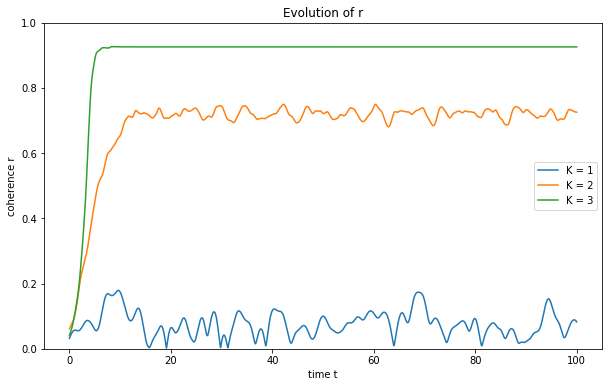

Wall time: 1min 38s


In [3]:
%%time


N = 500             # 1000
T = 100             # 100
dt = 0.01

numberOfTimes = int(T/dt)
t_range = [round(i * dt, 4) for i in range(numberOfTimes + 1)]      
K_range = [1, 2, 3]

rLists = [[]]

for K in K_range:
    pop2 = OscPopulation('normal')
    rList = pop2.runT(K)

    rLists.append(rList)





### graphing ###
plt.figure(figsize = (10,6))
plt.title('Evolution of r')
plt.ylim(0, 1)
plt.xlabel('time t')
plt.ylabel('coherence r')

for K in K_range:
    plt.plot(t_range, rLists[K], label = 'K = ' + str(K))
plt.legend()
filename = 'graphics/2_t-vs-r' + '_omegaDistr=' + pop2.omegaDistr + '_N=' + str(N) + '_' + str(int(time.time())) + '.pdf'
plt.savefig(filename, dpi = 200, bbox_inches = 'tight')
plt.show()









oscillators initialised with UNIFORM distibution of omegas
## 3 variables re-randomised ##
K = 0.0 | r_crit = 0.027
## 3 variables re-randomised ##
K = 0.03 | r_crit = 0.016
## 3 variables re-randomised ##
K = 0.06 | r_crit = 0.014
## 3 variables re-randomised ##
K = 0.09 | r_crit = 0.014
## 3 variables re-randomised ##
K = 0.12 | r_crit = 0.03
## 3 variables re-randomised ##
K = 0.15 | r_crit = 0.028
## 3 variables re-randomised ##
K = 0.18 | r_crit = 0.031
## 3 variables re-randomised ##
K = 0.21 | r_crit = 0.074
## 3 variables re-randomised ##
K = 0.24 | r_crit = 0.011
## 3 variables re-randomised ##
K = 0.27 | r_crit = 0.017
## 3 variables re-randomised ##
K = 0.3 | r_crit = 0.05
## 3 variables re-randomised ##
K = 0.33 | r_crit = 0.013
## 3 variables re-randomised ##
K = 0.36 | r_crit = 0.011
## 3 variables re-randomised ##
K = 0.39 | r_crit = 0.024
## 3 variables re-randomised ##
K = 0.42 | r_crit = 0.015
## 3 variables re-randomised ##
K = 0.45 | r_crit = 0.065
## 3 variables re

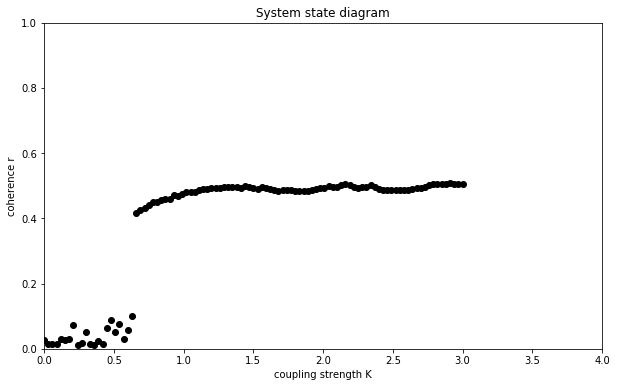

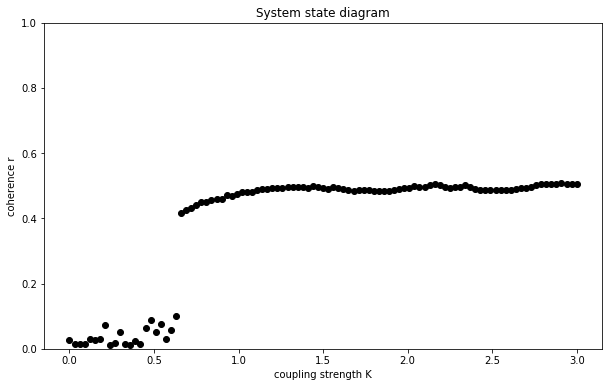

Wall time: 22min 45s


In [4]:
%%time


N = 1000                   # 2000    - 100, 100, took 6min
T = 200                   # 200
dt = 0.05
Kmax = 1.5
dk = 0.03

numberOfTimes = int(T/dt)
numberOfK = int(K/dk)
t_range = [round(i * dt, 4) for i in range(numberOfTimes + 1)]
K_range =  [round(i * dk, 4) for i in range(numberOfK + 1)]  

pop3 = OscPopulation('uniform')
r_critList = pop3.runK() 


# graphics 
plt.figure(figsize = (10,6))
plt.title('System state diagram')
plt.xlim(0, 4)
plt.ylim(0, 1)
plt.xlabel('coupling strength K')
plt.ylabel('coherence r')

plt.plot(K_range, r_critList, 'ko')
filename = 'graphics/3_K-vs-r' + '_omegaDistr=' + pop3.omegaDistr + '_N=' + str(N) + '_' + str(int(time.time())) + '.pdf'
plt.savefig(filename, dpi = 200, bbox_inches = 'tight')
plt.show()


# graphics 
plt.figure(figsize = (10,6))
plt.title('System state diagram')
plt.ylim(0, 1)
plt.xlabel('coupling strength K')
plt.ylabel('coherence r')

plt.plot(K_range, r_critList, 'ko')
filename = 'graphics/3 K-vs-r_' + 'omegaDistr=' + pop3.omegaDistr + '_zoomed' + '_N=' + str(N) + '_' + str(int(time.time())) + '.pdf'
plt.savefig(filename, dpi = 200, bbox_inches = 'tight')
plt.show()






oscillators initialised with UNIFORM distibution of omegas
oscillators initialised with UNIFORM distibution of omegas
original omegas restored
t = 0.0 done
t = 10.0 done
t = 20.0 done
t = 30.0 done
t = 40.0 done
t = 50.0 done
t = 60.0 done
t = 70.0 done
t = 80.0 done
t = 90.0 done
t = 100.0 done
t = 110.0 done
t = 120.0 done
t = 130.0 done
t = 140.0 done
t = 150.0 done
t = 160.0 done
t = 170.0 done
t = 180.0 done
t = 190.0 done
t = 200.0 done
############# run 0 done #############

oscillators initialised with UNIFORM distibution of omegas
original omegas restored
t = 0.0 done
t = 10.0 done
t = 20.0 done
t = 30.0 done
t = 40.0 done
t = 50.0 done
t = 60.0 done
t = 70.0 done
t = 80.0 done
t = 90.0 done
t = 100.0 done
t = 110.0 done
t = 120.0 done
t = 130.0 done
t = 140.0 done
t = 150.0 done
t = 160.0 done
t = 170.0 done
t = 180.0 done
t = 190.0 done
t = 200.0 done
############# run 1 done #############

oscillators initialised with UNIFORM distibution of omegas
original omegas restored
t

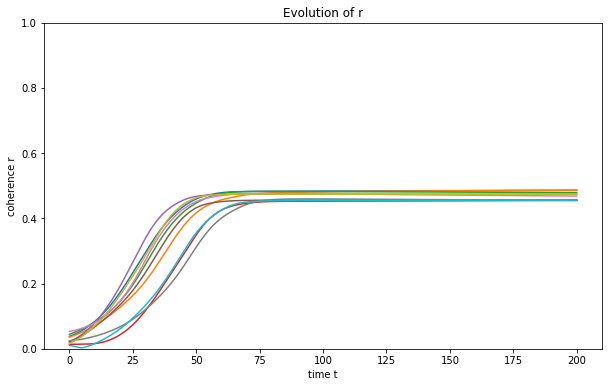

Wall time: 2min 26s


In [5]:
%%time
# --> same natural frequencies as first time, but start at different positions every time

N = 1000                      # 2000
T = 200                      # 200
dt = 0.05
runs = 10 

numberOfTimes = int(T/dt)
t_range = [round(i * dt, 4) for i in range(numberOfTimes + 1)]
K = 1               # 1

fixedOmegaPop = OscPopulation('uniform')
# savedOmegas = deepcopy(fixedOmegaPop)
rLists = []


for run in range(runs):
    _fixedOmegaPop = OscPopulation('uniform')

    for n in range(N): 
        _fixedOmegaPop.list_os[n].omega = fixedOmegaPop.list_os[n].omega
    print('original omegas restored')

    rNewList = _fixedOmegaPop.runT(K)
    rLists.append(rNewList)

    print('############# run', str(run), 'done #############\n') 


### graphing ###
plt.figure(figsize = (10,6))
plt.title('Evolution of r')
plt.ylim(0,1)
plt.xlabel('time t')
plt.ylabel('coherence r')

for run in range(runs):
    plt.plot(t_range, rLists[run])

filename = 'graphics/4_t-vs-r' + '_fixedOmegas' + '_omegaDistr=' + fixedOmegaPop.omegaDistr + '_N=' + str(N) + '_' + str(int(time.time())) + '.pdf'
plt.savefig(filename, dpi = 200, bbox_inches = 'tight')
plt.show()








oscillators initialised with UNIFORM distibution of omegas
oscillators initialised with UNIFORM distibution of omegas
original thetas restored
t = 0.0 done
t = 10.0 done
t = 20.0 done
t = 30.0 done
t = 40.0 done
t = 50.0 done
t = 60.0 done
t = 70.0 done
t = 80.0 done
t = 90.0 done
t = 100.0 done
t = 110.0 done
t = 120.0 done
t = 130.0 done
t = 140.0 done
t = 150.0 done
t = 160.0 done
t = 170.0 done
t = 180.0 done
t = 190.0 done
t = 200.0 done
############# run 0 done #############

oscillators initialised with UNIFORM distibution of omegas
original thetas restored
t = 0.0 done
t = 10.0 done
t = 20.0 done
t = 30.0 done
t = 40.0 done
t = 50.0 done
t = 60.0 done
t = 70.0 done
t = 80.0 done
t = 90.0 done
t = 100.0 done
t = 110.0 done
t = 120.0 done
t = 130.0 done
t = 140.0 done
t = 150.0 done
t = 160.0 done
t = 170.0 done
t = 180.0 done
t = 190.0 done
t = 200.0 done
############# run 1 done #############

oscillators initialised with UNIFORM distibution of omegas
original thetas restored
t

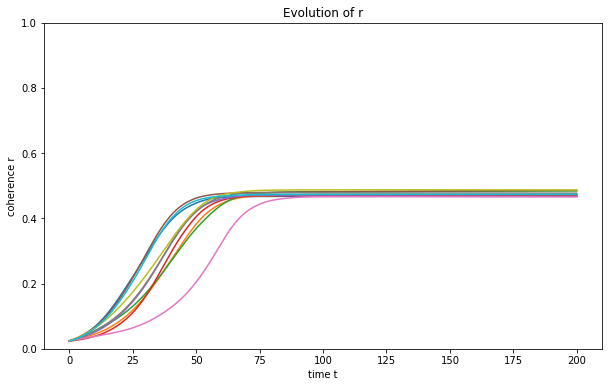

Wall time: 2min 31s


In [6]:
%%time
# --> have same positions as first run, but the natural frequencies get changed

N = 1000                  # 2000
T = 200                 # 200
dt = 0.05
runs = 10

numberOfTimes = int(T/dt)
t_range = [round(i * dt, 4) for i in range(numberOfTimes + 1)]
K = 1


fixedThetaPop = OscPopulation('uniform')
# savedThetas = deepcopy(fixedThetaPop)
rLists = []


for run in range(runs):
    _fixedThetaPop = OscPopulation('uniform')

    for n in range(N):
        _fixedThetaPop.list_os[n].currentTheta = fixedThetaPop.list_os[n].currentTheta
        _fixedThetaPop.list_os[n].lastTheta = 0.0
    print('original thetas restored')

    rNewList = _fixedThetaPop.runT(K)
    rLists.append(rNewList)

    print('############# run', str(run), 'done #############\n')


### graphing ###
plt.figure(figsize = (10,6))
plt.title('Evolution of r')
plt.ylim(0,1)
plt.xlabel('time t')
plt.ylabel('coherence r')

for run in range(runs):
    plt.plot(t_range, rLists[run])

filename = 'graphics/5_t-vs-r' + '_fixedThetas' + '_omegaDistr=' + fixedThetaPop.omegaDistr + '_N=' + str(N) + '_' + str(int(time.time())) + '.pdf'
plt.savefig(filename, dpi = 200, bbox_inches = 'tight')
plt.show()



